# Predictions
----
In this notewook, we will build a prediction model.

1. Predict whether a registered user will convert to a renter.
2. Give insights on which features are most predictive on users' conversion.

In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import sys
sys.path.append('../script')
# load the package for renter classification. 
import renter_classifier as rclf

# load the data.
data_path = '../source_data/renter_classifier/'
X1 = pd.read_csv(data_path+'X1.csv',index_col=0)
y1 = pd.read_csv(data_path+'y1.csv',index_col=0)

cat_features = ['email_cat','city_cat','age_cat','registered_by_fb']
num_features = ['sign_in_count','info_details','wish_items']

# log the columns that have a long tail
X1['sign_in_count'] = np.log(X1['sign_in_count']+1)
X1['wish_items'] = np.log(X1['wish_items']+1)


### Predicting 
This is an imbalanced data situation--3% of the useres converting to renters vs. 97% not. Therefore, we need to under-sample the users who do not convert.

In [2]:
def train_renter_classifier(X1,y1,under_sample = 0.04,
                           dummy_features=['email_cat',
                                         'city_cat','age_cat'],
                           drop_features = None):
    """
    Return a trained classifier using under_sampled data.
    dummy_features: features to be transformed to categorical features.
    drop_features: features to be deleted in order to reduce correlation.
    """
    
    # preprocess
    X_dummy = pd.get_dummies(X1,columns=dummy_features)
    if drop_features:
        X_dummy = X_dummy.drop(drop_features,axis=1)
    feature_names = X_dummy.columns

    # under sample the non-renters, and sample 80% of the renters.
    y_train = y1[~y1.values].sample(frac=under_sample).append(y1[y1.values]).sample(frac=0.8)
    X_train = X_dummy.loc[y_train.index.values,:]
  
    #X_train, X_test, y_train, y_test = train_test_split(X, y['Renter'], random_state=0)
    # Use X,y as training data, but each time only select 80% of it.
    y_test = y1.sample(frac=0.2)
    X_test = X_dummy.loc[y_test.index.values,:]
    
    X_train_scale = scale(X_train)
    X_test_scale = scale(X_test)
    
    log = LogisticRegression(penalty='l2',C=1)
    log.fit(X_train_scale,y_train)
    cm = confusion_matrix(y_test,log.predict(X_test_scale))
    
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    return feature_names, log, cm


#### Predict using all features

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


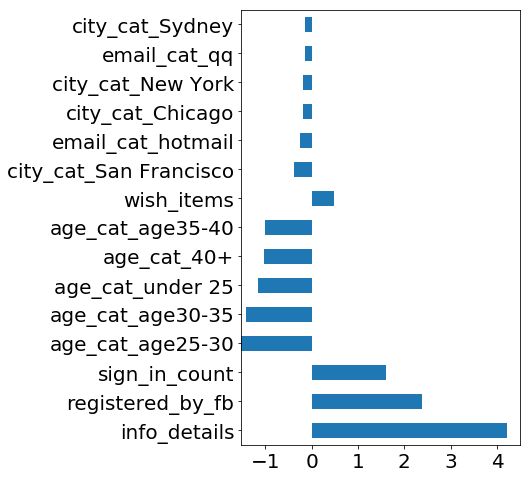

Confusion matrix, without normalization
[[ 0.68136552  0.31863448]
 [ 0.00171659  0.99828341]]


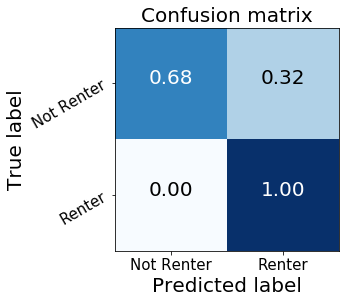

In [3]:
fake_features = ['age_cat_No_age',
                 'city_cat_No address','city_cat_Other City']

cms = [None]*20
coeffs = [None]*20
for i in range(20):
    feature_names, log, cms[i] = train_renter_classifier(X1,y1,drop_features=fake_features)
    coeffs[i] = log.coef_[0]
    
coeffs = pd.DataFrame(coeffs)
coeffs.columns = feature_names
coeffs = coeffs.fillna(0)


# select the top 20 most predictive features
means = pd.DataFrame(coeffs.mean())
means.columns=['coefficient']
means['abs'] = abs(means)
means = means.sort_values(['abs'],ascending=False)
means = means.drop(['abs'],axis=1)
means[0:15].plot(kind='barh',figsize=(5,8),fontsize=20,legend=False)

plt.show()
cm_mean = cms[0]
for i in range(19):
    cm_mean += cms[i+1]
cm_mean = cm_mean/20

# Plot non-normalized confusion matrix
plt.figure()
rclf.plot_confusion_matrix(cm_mean, classes=['Not Renter','Renter'],
                      title='Confusion matrix')

plt.show()

#### predicting using partial features

In [19]:
drop_features = ['age_cat_No_age','info_details','sign_in_count',
                 'city_cat_No address','city_cat_Other City','wish_items']

cms = [None]*20
coeffs = [None]*20
for i in range(20):
    feature_names, log, cms[i] = train_renter_classifier(X1,y1,drop_features=drop_features)
    coeffs[i] = log.coef_[0]

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
errors

city_cat_Newark           0.048599
city_cat_New York         0.048365
city_cat_Los Angeles      0.045093
city_cat_San Francisco    0.042548
city_cat_San Jose         0.062022
registered_by_fb          0.068526
city_cat_Dallas           0.036357
city_cat_Atlanta          0.054210
email_cat_hotmail         0.041153
city_cat_Ashburn          0.048851
city_cat_New Delhi        0.078609
city_cat_Singapore        0.063467
city_cat_Toronto          0.077282
email_cat_qq              0.100718
city_cat_Miami            0.042621
dtype: float64

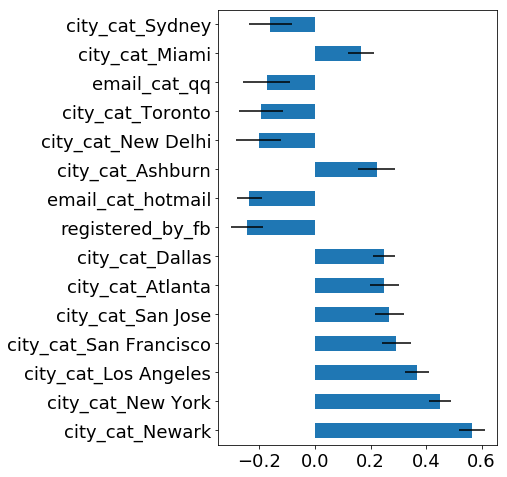

Confusion matrix, without normalization
[[ 0.60172529  0.39827471]
 [ 0.26913008  0.73086992]]


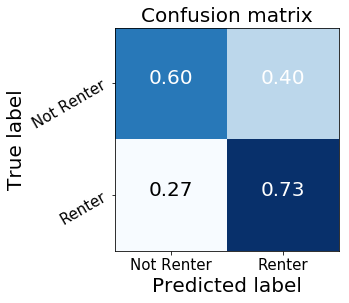

In [21]:
coeffs = pd.DataFrame(coeffs)
coeffs.columns = feature_names
coeffs = coeffs.fillna(0)


# select the top 20 most predictive features
means = pd.DataFrame(coeffs.mean())
means.columns=['coefficient']
means['abs'] = abs(means)
means = means.sort_values(['abs'],ascending=False)
means = means.drop(['abs'],axis=1)
means = means[0:15]

errors = coeffs.std()
errors = errors[means.index]
fig, ax = plt.subplots()
means.plot.barh(xerr=errors, ax=ax,figsize=(5,8),legend=False,fontsize=18)
plt.show()

cm_mean = cms[0]
for i in range(19):
    cm_mean += cms[i+1]
cm_mean = cm_mean/20

# Plot non-normalized confusion matrix
plt.figure()
rclf.plot_confusion_matrix(cm_mean, classes=['Not Renter','Renter'],
                      title='Confusion matrix')

plt.show()

END